In [196]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import pandas as pd
import json
from aggregation import *
from normalization import rank_normalization
from matplotlib.cm import get_cmap

import os, sys 
project_root = os.path.abspath("../") 
sys.path.append(project_root)
from models.preprocess import data_preprocessing


In [2]:
columns=['enroll_gest_age', 
         'enroll_delivery_status', 
         'g', 'p', 's', 'l', 
         'days_to_first_call', 
         'age_20-', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35+',
         'language_hindi', 'language_marathi', 'language_kannada', 'language_gujarati', 'language_english',
         'education_1-5', 'education_6-9', 'education_10_pass', 'education_12_pass', 'education_graduate', 'education_postgraduate', 'education_illiterate',
         'phone_woman', 'phone_husband', 'phone_family',
         'call_830-1030', 'call_1030-1230', 'call_1230-1530', 'call_1530-1730', 'call_1730-1930', 'call_1930-2130',
         'channel_community', 'channel_hospital', 'channel_ARMMAN',       
         'income_0-5000', 'income_5001-10000', 'income_10001-15000', 'income_15001-20000', 'income_20001-25000', 'income_25001-30000', 'income_30000+'
]

In [ ]:
def undo_one_hot_encoding(df_features):

    ## age 
    df_features['age'] = df_features[['age_20-', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35+']].idxmax(axis=1)
    df_features['age'] = df_features['age'].str.replace('age_', '') 

    ## education
    df_features['education'] = df_features[['education_1-5', 'education_6-9', 'education_10_pass', 'education_12_pass', 'education_graduate', 'education_postgraduate', 'education_illiterate']].idxmax(axis=1)
    df_features['education'] = df_features['education'].str.replace('education_', '') 

    ## income 
    df_features['income'] = df_features[['income_0-5000', 'income_5001-10000', 'income_10001-15000', 'income_15001-20000', 'income_20001-25000', 'income_25001-30000', 'income_30000+']].idxmax(axis=1)
    df_features['income'] = df_features['income'].str.replace('income_', '')  

    # call slot preference
    df_features['call_slot'] = df_features[['call_830-1030', 'call_1030-1230', 'call_1230-1530', 'call_1530-1730', 'call_1730-1930', 'call_1930-2130']].idxmax(axis=1)
    df_features['call_slot'] = df_features['call_slot'].str.replace('call_', '')  

    ## language 
    df_features['language'] = df_features[['language_hindi', 'language_marathi', 'language_kannada', 'language_gujarati', 'language_english']].idxmax(axis=1)
    df_features['language'] = df_features['language'].str.replace('language_', '')  

    return df_features

## Data

In [4]:
num_arms = 500
t1, t2 = 0, 40
models = ["anthropic", "google", "openai", "openaiheavy"]

In [9]:
model_results = {
        model: {
            "predictions": [f"../results/weekly/{model}_{num_arms}/all_individual_predictions_t1_{t1}_t2_{t2}.json"],
            "ground_truths": [f"../results/weekly/{model}_{num_arms}/ground_truths_t1_{t1}_t2_{t2}_week_{t2-1}.json"],
            "accuracies": [],
            "f1_scores": [],
            "log_likelihoods": [],
            "epistemic_uncertainty": [],
            "mean_predictions": []
        } for model in models
    }

# Storage for aggregated results
accuracies_agg, accuracies_avg = [], []
f1_scores_agg, f1_scores_avg = [], []
log_likelihoods_agg, log_likelihoods_avg = [], []

for model in models:
    # print(model)
    model_data = model_results[model] # dict for this model

    # Load predictions and ground truths
    # all_individual_preds : all 25 predictions for each arm and timestep [[],[],[],[],[]]
    all_individual_preds, ground_truths = load_predictions_and_ground_truths(
        model_data["predictions"][0], model_data["ground_truths"][0]
    )

    all_individual_preds = np.reshape(all_individual_preds, (t2-t1, num_arms, 5, 5))
    ground_truths = np.squeeze(ground_truths)

    # Loop over timesteps and arms, use ground truths to compare with predictions
    final_preds_all_time = []
    for t in range(t2-t1):
        gcs_at_t = ground_truths[t]
        final_preds_all_arms = []

        for arm in range(num_arms):
            prompts_runs = all_individual_preds[t][arm] # 5 * 5
            mean_predictions_per_prompt = np.mean(prompts_runs, axis=1) 
            final_mean_prediction = np.mean(mean_predictions_per_prompt) 
            final_preds_all_arms.append(final_mean_prediction)

        final_preds_all_time.append(final_preds_all_arms)

    # Calculate uncertainties
    timestep_ind_preds = restructure_predictions(all_individual_preds)
    for time_mat in timestep_ind_preds:
        epistemic_uncertainty, _, _ = compute_uncertainties_from_llm_predictions(time_mat) 
        epistemic_uncertainty = np.squeeze(epistemic_uncertainty)
        # print("epistemic_uncertainty: ", len(epistemic_uncertainty))
        model_data["epistemic_uncertainty"].append(epistemic_uncertainty)

    # Loop over timesteps for accuracy and aggregation calcs
    for t in range(t2-t1):  
        preds_at_t = [final_preds_all_time[t][arm] for arm in range(num_arms)]  
        gcs_at_t = ground_truths[t, :]  

        # Calc epistemic uncertainty and metrics for this timestep
        acc, f1, log_likelihood = compute_metrics(preds_at_t, gcs_at_t)

        # Append metrics for plotting
        model_data["accuracies"].append(acc)
        model_data["f1_scores"].append(f1)
        model_data["log_likelihoods"].append(log_likelihood)
        model_data["mean_predictions"].append(preds_at_t)


# print("Model results: ", model_results)

results_for_aggregation = {}
uncertainties_for_aggregation = {}
for model in models:
    for i, (result, uncertainty) in enumerate(zip(model_results[model]["mean_predictions"], model_results[model]["epistemic_uncertainty"])):
        results_for_aggregation.setdefault(i, []).append(result)
        uncertainties_for_aggregation.setdefault(i, []).append(uncertainty)


P_combined = []
P_direct_avg = []
for t in range(t2-t1):
    combined = bayesian_aggregation(predictions=results_for_aggregation[t],
                                    uncertainties=uncertainties_for_aggregation[t],
                                    normalization_method=rank_normalization
                                    )
    P_combined.append(combined)
    
    flattened_predictions = [np.array(p).flatten() for p in results_for_aggregation[t]]
    direct_avg = infer_posterior(*flattened_predictions)
    P_direct_avg.append(direct_avg)

# Calculate metrics for aggregated predictions
all_acc_agg, all_f1_agg, all_log_likelihood_agg = [], [], []
all_acc_avg, all_f1_avg, all_log_likelihood_avg = [], [], []
for i in range(len(P_combined)):
    acc_agg, f1_agg, log_likelihood_agg = compute_metrics(P_combined[i], ground_truths[i])
    all_acc_agg.append(acc_agg)
    all_f1_agg.append(f1_agg)
    all_log_likelihood_agg.append(log_likelihood_agg)
    acc_avg, f1_avg, log_likelihood_avg = compute_metrics(P_direct_avg[i], ground_truths[i])
    all_acc_avg.append(acc_avg)
    all_f1_avg.append(f1_avg)
    all_log_likelihood_avg.append(log_likelihood_avg)

In [41]:
features, state_trajectories, action_trajectories = data_preprocessing('../data/trajectories_continuous.json')
# 3k mothers, 43 features per mother --> need to select the first 500 mothers 
features = features[:500]
state_trajectories = state_trajectories[:500]
action_trajectories = action_trajectories[:500]

df_features = pd.DataFrame(features, columns=columns) # row per mother, cols rep features


Group random: Avg pulls = 0.015


In [43]:
df_features

,enroll_gest_age,enroll_delivery_status,g,p,s,l,days_to_first_call,age_20-,age_20-24,age_25-29,...,channel_community,channel_hospital,channel_ARMMAN,income_0-5000,income_5001-10000,income_10001-15000,income_15001-20000,income_20001-25000,income_25001-30000,income_30000+
0,19,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,19,0,2,1,0,1,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,15,0,2,0,0,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
3,25,0,2,1,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,12,0,1,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,14,1,2,1,0,1,13,0,1,0,...,0,0,0,0,1,0,0,0,0,0
496,16,0,1,1,0,0,7,0,0,1,...,0,0,0,0,0,0,1,0,0,0
497,10,0,1,1,0,0,5,0,1,0,...,0,0,0,0,0,0,1,0,0,0
498,21,0,1,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,0


## New functions

In [127]:
def compute_metrics_by_group(data, predictions, ground_truths, feature_categories, models, P_combined, P_direct_avg):

    metrics_by_group = {model: {} for model in models + ["Aggregated", "Averaged"]}

    # Loop over timesteps
    for t in range(ground_truths.shape[0]):  
        for category in feature_categories:
            # Filter data by feature category (boolean index for mothers)
            group_indices = data[category] == 1  # bool array of shape [mothers]
            # print(f"Category: {category}, Group Indices: {group_indices.sum()} mothers selected")
            group_ground_truths = ground_truths[t, group_indices]  

            # Compute metrics for each model
            for model in models:
                # Get predictions for this timestep and group
                group_predictions = np.array(predictions[model])[t, group_indices]

                # Compute metrics
                acc, f1, log_likelihood = compute_metrics(group_predictions, group_ground_truths)

                # Store metrics
                if category not in metrics_by_group[model]:
                    metrics_by_group[model][category] = {"Accuracy": [], "F1 Score": [], "Log Likelihood": []}
                metrics_by_group[model][category]["Accuracy"].append(acc)
                metrics_by_group[model][category]["F1 Score"].append(f1)
                metrics_by_group[model][category]["Log Likelihood"].append(log_likelihood)

            # Include aggregated and averaged models
            for aggregate_type, aggregate_preds in zip(["Aggregated", "Averaged"], [P_combined, P_direct_avg]):
                aggregate_preds = np.array(aggregate_preds)  # Convert to NumPy array
                group_aggregate_predictions = aggregate_preds[t, group_indices]
                acc, f1, log_likelihood = compute_metrics(group_aggregate_predictions, group_ground_truths)

                # Store metrics
                if category not in metrics_by_group[aggregate_type]:
                    metrics_by_group[aggregate_type][category] = {"Accuracy": [], "F1 Score": [], "Log Likelihood": []}
                metrics_by_group[aggregate_type][category]["Accuracy"].append(acc)
                metrics_by_group[aggregate_type][category]["F1 Score"].append(f1)
                metrics_by_group[aggregate_type][category]["Log Likelihood"].append(log_likelihood)

    return metrics_by_group

In [204]:
def plot_accuracy_by_feature(features=None, df=None, metric='accuracy', models=None, figsize=(14, 8)):
    
    if features is None: # default to all features in df
        features = df['feature'].unique()  

    if models is None: # default to all models in df
        models = df['model'].unique() 

    # set up axes
    num_features = len(features)
    num_cols = 2
    num_rows = math.ceil(num_features / num_cols) 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0], figsize[1] * num_rows), sharey=True)
    axes = axes.flatten() 

    bar_width = 0.15  

    for ax, feature in zip(axes, features):

        feature_df = df[df['feature'] == feature] 
        feature_categories = feature_df['category'].unique()
        x = np.arange(len(feature_categories))  # mid x pos for categories

        colormap = matplotlib.colormaps['tab10']
        model_colors = [colormap(i / len(models)) for i in range(len(models))]

        for i, model in enumerate(models):
            model_df = feature_df[feature_df['model'] == model]
            to_plot = model_df.groupby('category')[metric].mean()
            std_dev = model_df.groupby('category')[metric + '_std'].mean()

            # diff x positions for each model
            x_positions = x + i * bar_width

            # plot bars w error bars
            bars = ax.bar(x_positions, to_plot.values, 
                          yerr=std_dev.values, capsize=5, error_kw={'elinewidth': 2, 'alpha': 0.1, 'color': 'gray'},
                          width=bar_width, label=model, alpha=0.8, color=model_colors[i])

            # Print mean accuracy 
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, height+0.09, f'{height:.2f}', 
                        ha='center', va='bottom', fontsize=9, color='black', rotation=90)

        ax.set_title(f'{metric.capitalize()} by {feature.capitalize()}', fontsize=14)
        ax.set_xlabel(feature.capitalize(), fontsize=12)
        ax.set_xticks(x + bar_width * (len(models) - 1) / 2) 
        ax.set_xticklabels(feature_categories, rotation=70, fontsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Remove extra empty axes
    for ax in axes[num_features:]:
        ax.set_visible(False)

    axes[0].set_ylabel(metric.capitalize(), fontsize=12) 
    fig.legend(models, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(models), fontsize=12)
    fig.tight_layout()
    plt.show()


## Plotting

In [193]:
# Define all feature categories
all_categories = {
    'income': ['income_0-5000', 'income_5001-10000', 'income_10001-15000', 'income_15001-20000', 'income_20001-25000', 'income_25001-30000'],
    'age': ['age_20-', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35+'],
    'education': ['education_1-5', 'education_6-9', 'education_10_pass', 'education_12_pass', 'education_graduate', 'education_postgraduate', 'education_illiterate'], # 'education_postgraduate'
    'language': ['language_hindi', 'language_marathi', 'language_kannada', 'language_gujarati', 'language_english',], #  'language_gujarati', 'language_marathi'
    'call_times': ['call_830-1030', 'call_1030-1230', 'call_1230-1530', 'call_1530-1730', 'call_1730-1930', 'call_1930-2130']
}

plot_data = []

# Loop through all feature categories
for feature, feature_categories in all_categories.items():
    # Compute metrics by feature group
    metrics_by_feature = compute_metrics_by_group(
        data=df_features,
        predictions={model: model_results[model]["mean_predictions"] for model in models},
        ground_truths=ground_truths,
        feature_categories=feature_categories,
        models=models,
        P_combined=P_combined,
        P_direct_avg=P_direct_avg
    )

    # Convert to df for plotting
    for model, categories in metrics_by_feature.items():
        for category, metrics in categories.items():
            plot_data.append({
                'model': model,
                'feature': feature,    
                'category': category, 
                'accuracy': np.mean(metrics['Accuracy']),
                'accuracy_std': np.std(metrics['Accuracy']),
                'f1_score': np.mean(metrics['F1 Score']),
                'f1_score_std': np.std(metrics['F1 Score']),
                'log_likelihood': np.mean(metrics['Log Likelihood']),
                'log_likelihood_std': np.std(metrics['Log Likelihood'])
            })

plot_df = pd.DataFrame(plot_data)


/Users/smart/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/smart/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/smart/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/smart/Documents/Projects/Thesis/Teamcore/LLM-prediction/analysis/aggregation.py:52: RuntimeWarning: invalid value encountered in scalar divide
  log_likelihood = np.sum(
/Users/smart/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, *

In [194]:
plot_df

,model,feature,category,accuracy,accuracy_std,f1_score,f1_score_std,log_likelihood,log_likelihood_std
0,anthropic,income,income_0-5000,0.726389,0.098904,0.794086,0.094165,-4.451842,2.176179
1,anthropic,income,income_5001-10000,0.762742,0.045676,0.825045,0.048510,-3.669230,1.147157
2,anthropic,income,income_10001-15000,0.727315,0.052824,0.803573,0.055310,-4.138630,1.231341
3,anthropic,income,income_15001-20000,0.741011,0.057234,0.810883,0.056950,-3.674986,1.407659
4,anthropic,income,income_20001-25000,0.742188,0.089691,0.804720,0.093074,-4.242483,1.988332
...,...,...,...,...,...,...,...,...,...
169,Averaged,call_times,call_1030-1230,0.789567,0.038894,0.829623,0.043710,-4.628942,0.941270
170,Averaged,call_times,call_1230-1530,0.799684,0.053096,0.818001,0.051567,-4.463342,1.226335
171,Averaged,call_times,call_1530-1730,0.804819,0.054364,0.838085,0.060698,-4.313584,1.278325
172,Averaged,call_times,call_1730-1930,0.811025,0.029491,0.851077,0.039147,-4.175090,0.704120


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

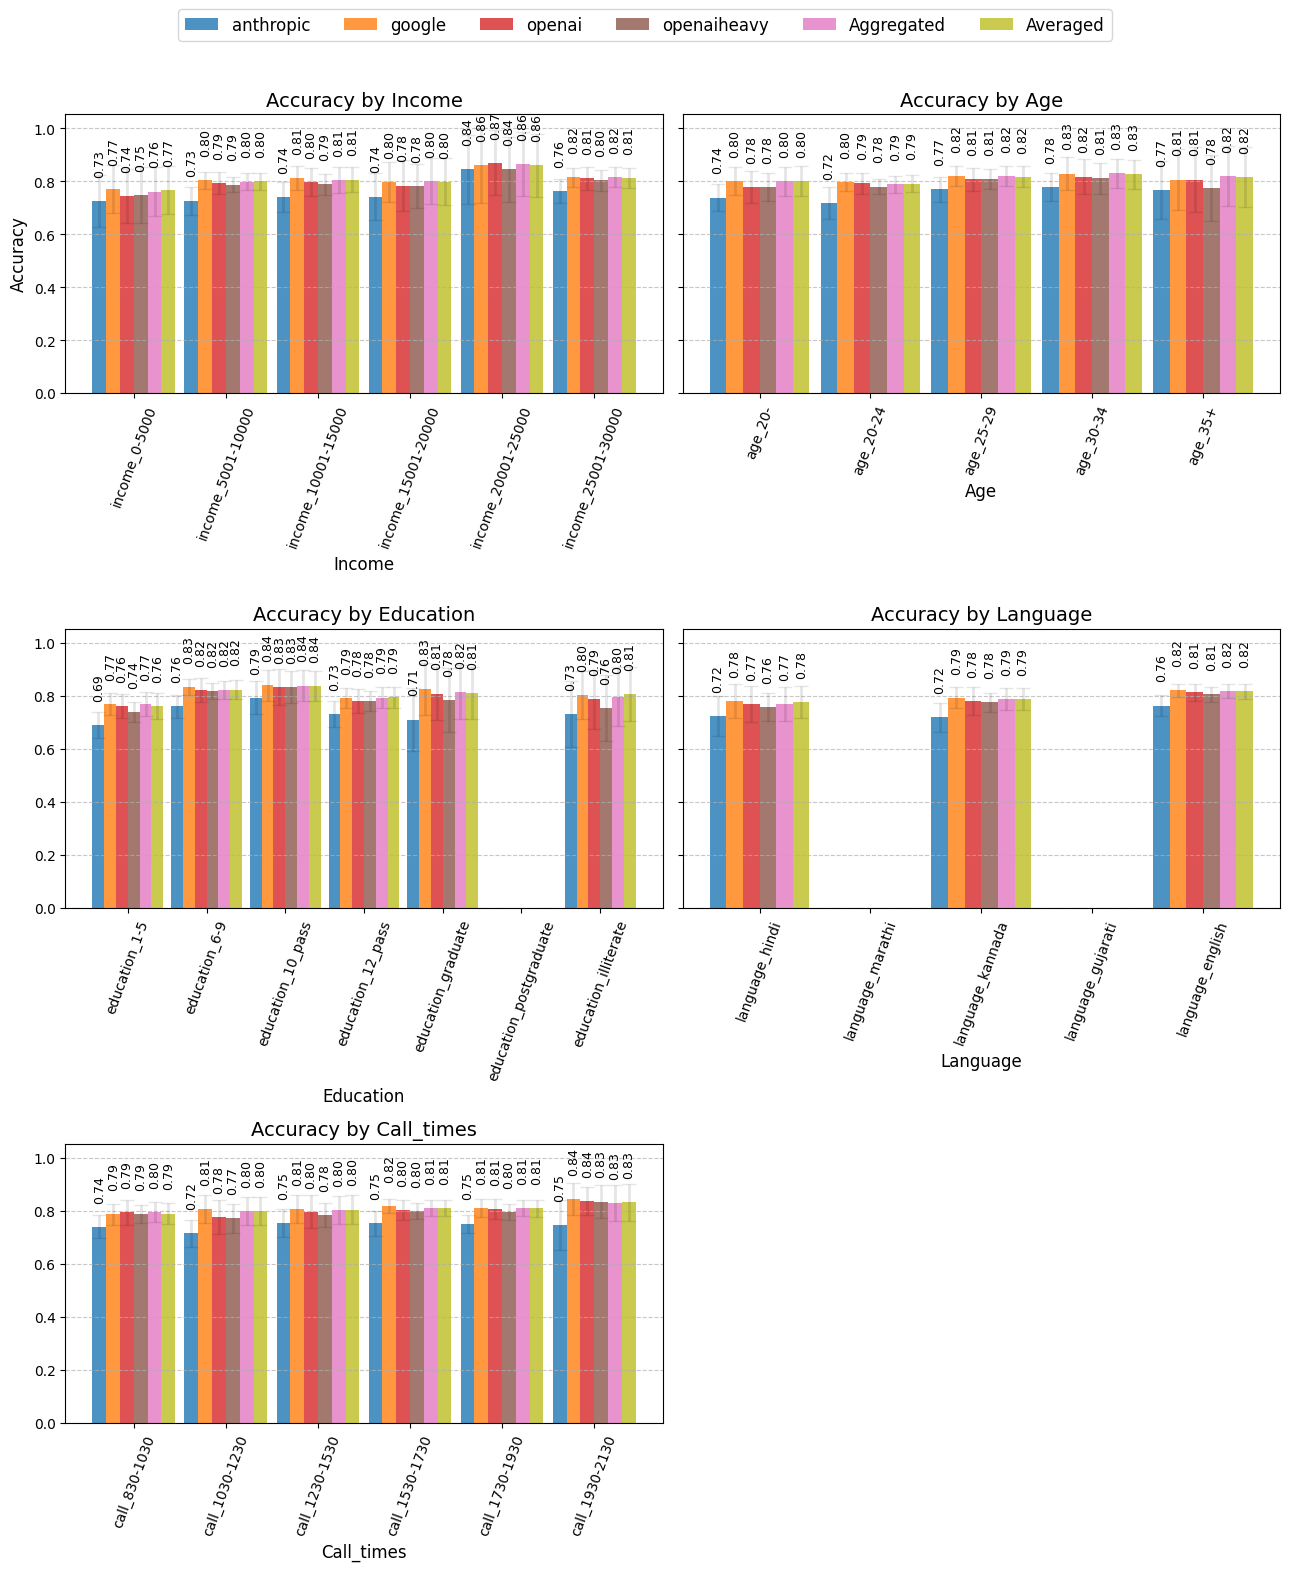

In [205]:
plot_accuracy_by_feature(
    df=plot_df,
    metric='accuracy',
    models=None,
    figsize=(13, 5)
)